# TODO:

1. Verify that the merge result is as expected.  I noticed that when I checked the length of the EPA for a 6-month period, the length was longer than the post-merge 6-month period.  This implies that the EIA data doesn't have some facilities that are listed in EPA.  I haven't verified this though.

2. NaN values also need to be replaced with 0's.

3. Numbers are being stored in scientific notation

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
import cPickle as pickle
import gzip
import seaborn as sns

## Loading the EIA Data, the path may need to be updated...
This will take a few minutes to run.

In [2]:
#Iterate through the directory to find all the files to import
#Modified so that it also works on macs
path = os.path.join('EIA Data', '923-No_Header')
full_path = os.path.join(path, '*.*')


eiaNames = os.listdir(path)

#Rename the keys for easier merging later
fileNameMap = {'EIA923 SCHEDULES 2_3_4_5 Final 2010.xls':2010,
                'EIA923 SCHEDULES 2_3_4_5 M Final 2009 REVISED 05252011.XLS':2009,
                'eia923December2008.xls':2008,
                'EIA923_Schedules_2_3_4_5_2011_Final_Revision.xlsx':2011,
                'EIA923_Schedules_2_3_4_5_2012_Final_Release_12.04.2013.xlsx':2012,
                'EIA923_Schedules_2_3_4_5_2013_Final_Revision.xlsx':2013,
                'EIA923_Schedules_2_3_4_5_M_12_2014_Final_Revision.xlsx':2014,
                'EIA923_Schedules_2_3_4_5_M_12_2015_Final.xlsx':2015,
                'f906920_2007.xls':2007}

#Load the files into data frames, one df per file
eiaDict = {fileNameMap[fn]:pd.read_excel(os.path.join(path, fn)) for fn in eiaNames}
eiaDict = {key:val[val["NERC Region"] == "TRE"] for key, val in eiaDict.iteritems()}

The excel documents have different column names so we need to standardize them all

In [3]:
#Dict of values to replace to standardize column names across all dataframes
monthDict = {"JANUARY":"JAN",
           "FEBRUARY":"FEB",
           "MARCH":"MAR",
           "APRIL":"APR",
           "MAY":"MAY",
           "JUNE":"JUN",
           "JULY":"JUL",
           "AUGUST":"AUG",
           "SEPTEMBER":"SEP",
           "OCTOBER":"OCT",
           "NOVEMBER":"NOV",
           "DECEMBER":"DEC"}
           
replaceDict = {"ELECTRIC":"ELEC",
               "&":"AND",
               "I.D.":"ID",
               "MMBTUPER":"MMBTU_PER"}
               
#Add "MMBTUMON" : "MMBTU_MON" to be replaced
for month in monthDict.values():
    replaceDict["MMBTU"+month] = "MMBTU_" + month

#Replace the column name
def rename(col):
    for old, new in monthDict.iteritems():
        col = col.replace(old, new)
        
    for old, new in replaceDict.iteritems():
        col = col.replace(old, new)
        
    col = col.replace("MMBTUS", "MMBTU")
    return col
    
#Iterate through each column name of each dataframe to standardize
for key, df in eiaDict.iteritems():
    colNames = [name.replace("\n", "_").replace(" ", "_").strip().upper() for name in df.columns]
    colNames = [rename(col) for col in colNames]
    eiaDict[key].columns = colNames

Define which columns we need to sum, and which columns don't need to be summed, but we still need to keep.

Note: If we don't care about monthly stuff we can delete the second block of code.

In [4]:
#Define the columns that are necessary but are not summable
allCols = eiaDict[fileNameMap.values()[0]].columns
nonSumCols = ["PLANT_ID", "PLANT_NAME", "YEAR"]

#Define the columns that contain the year's totals (Used to calc fuel type %)
yearCols = ["TOTAL_FUEL_CONSUMPTION_QUANTITY", "ELEC_FUEL_CONSUMPTION_QUANTITY",
            "TOTAL_FUEL_CONSUMPTION_MMBTU", "ELEC_FUEL_CONSUMPTION_MMBTU",
            "NET_GENERATION_(MEGAWATTHOURS)"]


#Define the columns that are necessary and summable
sumCols = []
sumCols.extend(yearCols)
# regex = re.compile(r"^ELEC_QUANTITY_.*")
# sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^MMBTU_PER_UNIT_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^TOT_MMBTU_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^ELEC_MMBTUS_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^NETGEN_.*")
sumCols.extend([col for col in allCols if regex.search(col)])

Get a list of all the different fuel type codes.  If we don't care about all of them, then just hardcode the list

In [5]:
fuelTypes = []
fuelTypes.extend([fuelType for df in eiaDict.values() for fuelType in df["REPORTED_FUEL_TYPE_CODE"].tolist()])
fuelTypes = set(fuelTypes)

In [6]:
fuelTypes

{u'AB',
 u'BIT',
 u'BLQ',
 u'DFO',
 u'JF',
 u'LFG',
 u'LIG',
 u'MWH',
 u'NG',
 u'NUC',
 u'OBG',
 u'OBL',
 u'OBS',
 u'OG',
 u'OTH',
 u'PC',
 u'PUR',
 u'RFO',
 u'SC',
 u'SUB',
 u'SUN',
 u'WAT',
 u'WDS',
 u'WH',
 u'WND',
 u'WO'}

3 parts to aggregate by facility, and to calculate the % of each type of fuel.  This will take a few minutes to run.

The end result is aggEIADict.

In [6]:
#Actually calculate the % type for each facility grouping
def calcPerc(group, aggGroup, fuelType, col):
    #Check to see if the facility has a record for the fuel type, and if the total column > 0
    if len(group[group["REPORTED_FUEL_TYPE_CODE"] == fuelType]) > 0 and aggGroup[col] > 0:
        #summing fuel type because a facility may have multiple plants with the same fuel type        
        return float((group[group["REPORTED_FUEL_TYPE_CODE"] == fuelType][col]).sum())/aggGroup[col] 
    else:
        return 0

#Perform the aggregation on facility level
def aggAndCalcPerc(group):
    aggGroup = group.iloc[0][nonSumCols] #Get the non-agg columns
    aggGroup = aggGroup.append(group[sumCols].sum())   #Aggregate the agg columns and append to non-agg
    percCols = {col + " %" + fuelType:calcPerc(group, aggGroup, fuelType, col) for col in yearCols for fuelType in fuelTypes}
    aggGroup = aggGroup.append(pd.Series(percCols))
    return aggGroup    

#Iterate through each dataframe to perform aggregation by facility
aggEIADict = dict()
for key, df in eiaDict.iteritems():
    gb = df.groupby(by="PLANT_ID")
    #aggGroup will be a list of panda series, each series representing a facility
    aggGroup = [aggAndCalcPerc(gb.get_group(group)) for group in gb.groups]
    aggEIADict[key] = pd.DataFrame(aggGroup)

### NOT ALL YEARS MATCH

In [28]:
aggEIADict[2007].head()

,PLANT_ID,PLANT_NAME,YEAR,TOTAL_FUEL_CONSUMPTION_QUANTITY,ELEC_FUEL_CONSUMPTION_QUANTITY,TOTAL_FUEL_CONSUMPTION_MMBTU,ELEC_FUEL_CONSUMPTION_MMBTU,NET_GENERATION_(MEGAWATTHOURS),MMBTU_PER_UNIT_JAN,MMBTU_PER_UNIT_FEB,...,TOTAL_FUEL_CONSUMPTION_QUANTITY %PUR,TOTAL_FUEL_CONSUMPTION_QUANTITY %RFO,TOTAL_FUEL_CONSUMPTION_QUANTITY %SC,TOTAL_FUEL_CONSUMPTION_QUANTITY %SUB,TOTAL_FUEL_CONSUMPTION_QUANTITY %SUN,TOTAL_FUEL_CONSUMPTION_QUANTITY %WAT,TOTAL_FUEL_CONSUMPTION_QUANTITY %WDS,TOTAL_FUEL_CONSUMPTION_QUANTITY %WH,TOTAL_FUEL_CONSUMPTION_QUANTITY %WND,TOTAL_FUEL_CONSUMPTION_QUANTITY %WO
0,3584,H 5,2007,0.0,0.0,109110.0,109110.0,1.103900e+04,0.000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3585,Nolte,2007,0.0,0.0,118993.0,118993.0,1.203900e+04,0.000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3586,TP 4,2007,0.0,0.0,142735.0,142735.0,1.444100e+04,0.000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,6147,Monticello,2007,11807274.0,11807274.0,171279117.0,171279117.0,1.539900e+07,34.452,34.281,...,0.0,0.0,0.0,0.529492,0.0,0.0,0.0,0.0,0.0,0.0
4,6145,Comanche Peak,2007,0.0,0.0,197597659.0,197597659.0,1.884575e+07,0.000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
aggEIADict[2015].head()

,ELEC_FUEL_CONSUMPTION_MMBTU,ELEC_FUEL_CONSUMPTION_MMBTU %AB,ELEC_FUEL_CONSUMPTION_MMBTU %BIT,ELEC_FUEL_CONSUMPTION_MMBTU %BLQ,ELEC_FUEL_CONSUMPTION_MMBTU %DFO,ELEC_FUEL_CONSUMPTION_MMBTU %JF,ELEC_FUEL_CONSUMPTION_MMBTU %LFG,ELEC_FUEL_CONSUMPTION_MMBTU %LIG,ELEC_FUEL_CONSUMPTION_MMBTU %MWH,ELEC_FUEL_CONSUMPTION_MMBTU %NG,...,TOT_MMBTU_FEB,TOT_MMBTU_JAN,TOT_MMBTU_JUL,TOT_MMBTU_JUN,TOT_MMBTU_MAR,TOT_MMBTU_MAY,TOT_MMBTU_NOV,TOT_MMBTU_OCT,TOT_MMBTU_SEP,YEAR
0,72974.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,616,9958,3599,12099,6202,9885,4957,1794,3645,2015
1,67999.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,574,9279,3354,11274,5779,9211,4619,1672,3396,2015
2,87001.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,735,11872,4291,14425,7394,11785,5910,2139,4345,2015
3,60253204.0,0.0,0.0,0.0,0.003132,0.0,0.0,0.145169,0.0,0.0,...,...,...,16116830,10240752,0,1480872,5146811,5375612,5227114,2015
4,4059804.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,349648,358283,344795,287042,278416,296580,405538,320529,321004,2015


### Export the EIA 923 data
Just sending the dictionary to a pickle file for now. At least doing this will save several min of time loading and processing the data in the future.

In [9]:
filename = 'EIA 923.pkl'
path = '../Clean Data'
fullpath = os.path.join(path, filename)

pickle.dump(aggEIADict, open(fullpath, 'wb'))

## Loading the EPA Data, the path may need to be updated...

In [2]:
#Read the EPA files into a dataframe
path2 = os.path.join('EPA air markets')
epaNames = os.listdir(path2)
filePaths = {dn:os.path.join(path2, dn, "*.txt") for dn in epaNames}
filePaths = {dn:glob.glob(val) for dn, val in filePaths.iteritems()}
epaDict = {key:pd.read_csv(fp, index_col = False) for key, val in filePaths.iteritems() for fp in val}

First rename the column name so we can merge on that column, then change the datatype of date to a datetime object

In [3]:
#Rename the column names to remove the leading space.
for key, df in epaDict.iteritems():
    colNames = [name.upper().strip() for name in df.columns]
    colNames[colNames.index("FACILITY ID (ORISPL)")] = "PLANT_ID"
    epaDict[key].columns = colNames
    
#Convert DATE to datetime object
#Add new column DATETIME with both date and hour
for key, df in epaDict.iteritems():
    epaDict[key]["DATE"] = pd.to_datetime(df["DATE"])
    epaDict[key]['DATETIME'] = df['DATE'] + pd.to_timedelta(df['HOUR'], unit='h')

The DataFrames in `epaDict` contain all power plants in Texas. We can filter on `NERC REGION` so that it only includes ERCOT.

In [4]:
set(epaDict['2015 July-Dec'].loc[:,'NERC REGION'])

{nan, 'ERCOT', 'SERC', 'SPP', 'WECC'}

In [5]:
#Boolean filter to only keep ERCOT plants
for key, df in epaDict.iteritems():
    epaDict[key] = df[df["NERC REGION"] == "ERCOT"].reset_index(drop = True)
    

In [6]:
set(epaDict['2015 July-Dec'].loc[:,'NERC REGION'])

{'ERCOT'}

In [7]:
epaDict['2015 July-Dec'].head()

,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2015,2015-07-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 00:00:00
1,TX,Barney M. Davis,4939,2015,2015-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 01:00:00
2,TX,Barney M. Davis,4939,2015,2015-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 02:00:00
3,TX,Barney M. Davis,4939,2015,2015-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 03:00:00
4,TX,Barney M. Davis,4939,2015,2015-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 04:00:00


### Export EPA data as a series of dataframes
The whole dictionary is too big as a pickle file

In [8]:
# pickle with gzip, from http://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)

In [10]:
filename = 'EPA hourly dictionary.pgz'
path = '../Clean Data'
fullpath = os.path.join(path, filename)

save_zipped_pickle(epaDict, fullpath)

In [30]:
df = epaDict['2015 July-Dec']

In [59]:
df.head()

,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,datetime
0,TX,Barney M. Davis,4939,2015,2015-07-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 00:00:00
1,TX,Barney M. Davis,4939,2015,2015-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 01:00:00
2,TX,Barney M. Davis,4939,2015,2015-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 02:00:00
3,TX,Barney M. Davis,4939,2015,2015-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 03:00:00
4,TX,Barney M. Davis,4939,2015,2015-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 04:00:00


In [56]:
set(df['PLANT_ID'])

{127,
 298,
 3439,
 3441,
 3443,
 3452,
 3453,
 3460,
 3464,
 3468,
 3469,
 3470,
 3476,
 3477,
 3478,
 3490,
 3491,
 3492,
 3494,
 3497,
 3504,
 3507,
 3548,
 3559,
 3576,
 3601,
 3611,
 3612,
 3628,
 3631,
 4266,
 4937,
 4939,
 6136,
 6139,
 6147,
 6178,
 6179,
 6180,
 6181,
 6183,
 6243,
 6648,
 7030,
 7097,
 7325,
 7900,
 8063,
 52176,
 55015,
 55091,
 55139,
 55153,
 55215,
 55223,
 56350,
 56674}

In [80]:
df_temp = df[df['PLANT_ID'].isin([127, 298, 3439])].fillna(0)

In [81]:
df_temp.head()

,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,datetime
79488,TX,Laredo,3439,2015,2015-07-01,0,0.0,0.0,0.0,0.0,0.0,6,ERCOT,Webb,0.0,27.5667,-99.5083,2015-07-01 00:00:00
79489,TX,Laredo,3439,2015,2015-07-01,1,0.0,0.0,0.0,0.0,0.0,6,ERCOT,Webb,0.0,27.5667,-99.5083,2015-07-01 01:00:00
79490,TX,Laredo,3439,2015,2015-07-01,2,0.0,0.0,0.0,0.0,0.0,6,ERCOT,Webb,0.0,27.5667,-99.5083,2015-07-01 02:00:00
79491,TX,Laredo,3439,2015,2015-07-01,3,0.0,0.0,0.0,0.0,0.0,6,ERCOT,Webb,0.0,27.5667,-99.5083,2015-07-01 03:00:00
79492,TX,Laredo,3439,2015,2015-07-01,4,0.0,0.0,0.0,0.0,0.0,6,ERCOT,Webb,0.0,27.5667,-99.5083,2015-07-01 04:00:00


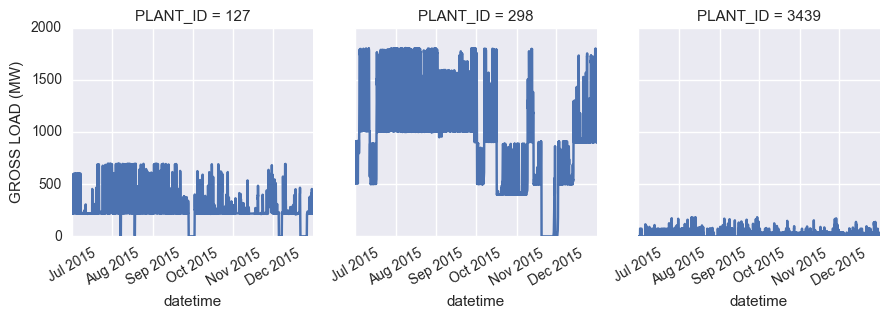

In [84]:
g = sns.FacetGrid(df_temp, col='PLANT_ID')
g.map(plt.plot, 'datetime', 'GROSS LOAD (MW)')
g.set_xticklabels(rotation=30)

path = os.path.join('..', 'Exploratory visualization', 'Midterm figures', 'Sample hourly load.svg')
plt.savefig(path)

## Finally join the two data sources

Switch to an inner join?

**No need to join. Can keep them as separate databases, since one is hourly data and the other is annual/monthly** Create a clustering dataframe with index of all plant IDs (from the EPA hourly data), add columns with variables. Calculate the inputs in separate dataframes - example is to calculate ramp rate values in the EPA hourly data, then put the results in the clustering dataframe.

In [13]:
#Join the two data sources on PLANT_ID
fullData = {key:df.merge(aggEIADict[df["YEAR"][0]], on="PLANT_ID") for key, df in epaDict.iteritems()}

In [14]:
fullData[fullData.keys()[0]].head()

,STATE,FACILITY NAME,PLANT_ID,YEAR_x,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),...,TOT_MMBTU_FEB,TOT_MMBTU_JAN,TOT_MMBTU_JUL,TOT_MMBTU_JUN,TOT_MMBTU_MAR,TOT_MMBTU_MAY,TOT_MMBTU_NOV,TOT_MMBTU_OCT,TOT_MMBTU_SEP,YEAR_y
0,TX,Barney M. Davis,4939,2012,2012-01-01,0,NaN,NaN,NaN,NaN,...,1.49482e+06,1.28956e+06,1.98845e+06,2.02212e+06,1.93844e+06,2.06786e+06,905868,1.51242e+06,1.88822e+06,2012
1,TX,Barney M. Davis,4939,2012,2012-01-01,1,NaN,NaN,NaN,NaN,...,1.49482e+06,1.28956e+06,1.98845e+06,2.02212e+06,1.93844e+06,2.06786e+06,905868,1.51242e+06,1.88822e+06,2012
2,TX,Barney M. Davis,4939,2012,2012-01-01,2,NaN,NaN,NaN,NaN,...,1.49482e+06,1.28956e+06,1.98845e+06,2.02212e+06,1.93844e+06,2.06786e+06,905868,1.51242e+06,1.88822e+06,2012
3,TX,Barney M. Davis,4939,2012,2012-01-01,3,NaN,NaN,NaN,NaN,...,1.49482e+06,1.28956e+06,1.98845e+06,2.02212e+06,1.93844e+06,2.06786e+06,905868,1.51242e+06,1.88822e+06,2012
4,TX,Barney M. Davis,4939,2012,2012-01-01,4,NaN,NaN,NaN,NaN,...,1.49482e+06,1.28956e+06,1.98845e+06,2.02212e+06,1.93844e+06,2.06786e+06,905868,1.51242e+06,1.88822e+06,2012


BIT, SUB, LIG, NG, DFO, RFO

In [15]:
[x for x in fullData[fullData.keys()[0]].columns]

['STATE',
 'FACILITY NAME',
 'PLANT_ID',
 'YEAR_x',
 'DATE',
 'HOUR',
 'GROSS LOAD (MW)',
 'STEAM LOAD (1000LB/HR)',
 'SO2 (POUNDS)',
 'NOX (POUNDS)',
 'CO2 (SHORT TONS)',
 'HEAT INPUT (MMBTU)',
 'EPA REGION',
 'NERC REGION',
 'COUNTY',
 'FACILITY LATITUDE',
 'FACILITY LONGITUDE',
 u'ELEC_FUEL_CONSUMPTION_MMBTU',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %AB',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %BIT',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %BLQ',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %DFO',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %JF',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %LFG',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %LIG',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %MWH',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %NG',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %NUC',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %OBG',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %OBL',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %OBS',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %OG',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %OTH',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %PC',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %PUR',
 u'ELEC_FUEL_CONSUMPTION_MMBTU %RFO',
 u'ELE

## Loading EIA 860 Data


In [10]:
# Iterate through the directory to find all the files to import
path = os.path.join('EIA Data', '860-No_Header')
full_path = os.path.join(path, '*.*')

eia860Names = os.listdir(path)

# Rename the keys for easier merging later
fileName860Map = {  'GenY07.xls':2007,
                    'GenY08.xls':2008,
                    'GeneratorY09.xls':2009,
                    'GeneratorsY2010.xls':2010,
                    'GeneratorY2011.xlsx':2011,
                    'GeneratorY2012.xlsx':2012,
                    '3_1_Generator_Y2013.xlsx':2013,
                    '3_1_Generator_Y2014.xlsx':2014,
                    '3_1_Generator_Y2015.xlsx':2015}

#Load the files into data frames, one df per file
eia860Dict = {fileName860Map[fn]:pd.read_excel(os.path.join(path, fn)) for fn in eia860Names}  

In [11]:
#Dict of values to replace to standardize column names across all dataframes
renameDict = {  "PLNTCODE":"PLANT_ID",
                "PLANT_CODE":"PLANT_ID",
                "Plant Code":"PLANT_ID",
                "NAMEPLATE":"NAMEPLATE_CAPACITY(MW)",
                "Nameplate Capacity (MW)":"NAMEPLATE_CAPACITY(MW)"}

#Replace the column name
def rename860(col):
    for old, new in renameDict.iteritems():
        col = col.replace(old, new)
    return col

#Iterate through each column name of each dataframe to standardize and select columns 'PLANT_ID', 'NAMEPLATE_CAPACITY(MW)'
for key, df in eia860Dict.iteritems():
    colNames = [rename860(col) for col in df.columns]
    eia860Dict[key].columns = colNames
    eia860Dict[key] = eia860Dict[key][["PLANT_ID", "NAMEPLATE_CAPACITY(MW)"]]

In [12]:
# verify the tables
for key, df in eia860Dict.iteritems():
    print key, df.columns, len(df)

2007 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 19060
2008 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 19558
2009 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 17876
2010 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 18150
2011 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 18530
2012 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 19023
2013 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 19243
2014 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 19745
2015 Index([u'PLANT_ID', u'NAMEPLATE_CAPACITY(MW)'], dtype='object') 20068


In [13]:
# Iterate through each dataframe to perform aggregation by PLANT_ID
for key, df in eia860Dict.iteritems():
    gb = df.groupby(by='PLANT_ID').apply(lambda x: x['NAMEPLATE_CAPACITY(MW)'].sum())
    eia860Dict[key]['NAMEPLATE_CAPACITY(MW)'] = eia860Dict[key].PLANT_ID.apply(gb.get_value)
    eia860Dict[key] = eia860Dict[key].drop_duplicates(subset=['PLANT_ID', 'NAMEPLATE_CAPACITY(MW)'])
    eia860Dict[key] = eia860Dict[key].sort_values(by='PLANT_ID').reset_index(drop=True)

### Export EIA 860 data

In [17]:
filename = 'EIA 860.pkl'
path = '../Clean Data'
fullpath = os.path.join(path, filename)

pickle.dump(eia860Dict, open(fullpath, 'wb'))

## Creating Final DataFrame for Clustering Algorithm:
#### clusterDict {year : cluster_DF}

1. For each PLANT_ID in aggEIADict, fetch the corresponding aggregated NAMEPLATE_CAPACITY(MW)

In [14]:
clusterDict = dict()
for key, df in eia860Dict.iteritems():
    clusterDict[key] = pd.merge(aggEIADict[key], eia860Dict[key], how='left', on='PLANT_ID')[['PLANT_ID', 'NAMEPLATE_CAPACITY(MW)']]

In [15]:
# verify for no loss of data
for key, df in eia860Dict.iteritems():
    print key, len(clusterDict[key]), len(aggEIADict[key])

2007 216 216
2008 234 234
2009 245 245
2010 253 253
2011 257 257
2012 274 274
2013 282 282
2014 291 291
2015 312 312


In [16]:
clusterDict[2015].head()

,PLANT_ID,NAMEPLATE_CAPACITY(MW)
0,3584,2.4
1,3585,2.4
2,3586,2.4
3,6147,1980.0
4,58372,135.4


## Calculating ramp rate
Calculate rate of change over 1,2,3 hours for positive change. 

# Assumptions
1. Plant capacity changes at the start of the year and is constant for the entire year
2. Same for ramp rate - no changes over the course of the year